# Exam Data Science I  
### Exam I in the Summer Term 2024

## General Information

* You have one week to complete the exam. 

* You can use all sources freely, but you must name them correctly. If you use ChatGPT or similar software, you must include the prompt.

* You should use the following packages: `numpy, pandas, scipy, geopy, scikit-learn/sklearn, matplotlib, seaborn, openpyxl` and Python's native libraries. These are sufficient to solve the exam. If you use other libraries, justify their use.

* Code must be sufficiently commented to be understandable. Write functions whenever you reuse code. In general, follow the guidelines from the lecture. Points may be deducted due to poorly structured or incomprehensible code.

* **Always justify (!)** decisions regarding the choice of plots, hypothesis tests, etc. in writing and **interpret** your results.

* You are **not** allowed to seek help or advice from other people in any way. 

* Please submit the complete repository as a `.zip` file with the name `surname_matrikelnummer.zip` by August 8th, 2024 at 12:00 noon on StudIP to the folder `Submission - Exam 1`.

* Also add the signed code of conduct to the `.zip` file. 

* If you have any questions, please contact us via Rocketchat in a timely manner.

## Exercises and Points:

<table>
  <thead>
    <tr>
      <th colspan="3">Exercise 1 - Data Preprocessing</th>
      <th colspan="2">Exercise 2 - Plotting</th>
      <th colspan="2">Exercise 3 - Statistics</th>
      <th colspan="2">Exercise 4 - Machine Learning </th>
    </tr>
    <tr>
      <th>Exercise 1.1</th>
      <th>Exercise 1.2</th>
      <th>Exercise 1.3</th>
      <th>Exercise 2.1</th>
      <th>Exercise 2.2</th>
      <th>Exercise 3.1</th>
      <th>Exercise 3.2</th>
      <th>Exercise 4.1</th>
      <th>Exercise 4.2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10 points </td>
      <td>12 points </td>
      <td>2 points </td>
      <td>11 points</td>
      <td>27 points </td>
      <td>13 points </td>
      <td>5 points </td>
      <td>10 points </td>
      <td>10 points </td>
    </tr>
    <!-- Add more rows as needed -->
  </tbody>
</table>


_____
## Exercise 0: Setup

The exam folder contains a `Dockerfile` in which all relevant libraries are defined. The `Dockerfile` builds up on the Jupyter Server image. Use this Dockerfile to first create a Docker image and then start a Docker container from that image. Afterwards log into the Jupyter Server instance to work on the exam. We strongly recommend using the Docker environment to avoid version conflicts between the various libraries. Code that does not run in this environment will be graded as **non functional**.

____
## Exercise 1: Data Preprocessing (24 points)

### Data Description

In the data folder, you will find the parking data in Göttingen city for the year 2023 as one file per month. The parking tickets bought using the stationary ticket machines are in the files whose names start with `Cale` and the parking tickets bought with the parkster app are in the files whose names start with `Parkster`. <br> 
The file `parkzone_latlong.csv` provides further geographical information regarding the parkzones and the file `psa_latlong.csv` provides geographical information about the parking machines within the parkzones.

The parking data provided is genuine raw data and comes directly from the city of Göttingen. We have only added the geographical information. 

*Please note:*
- *in the following the term "parking ticket" refers to a piece of paper that entitles you to park and not a fine for illegal parking.*
- *although we only have data from February to December, we will refer to all data available as yearly.*
- *due to the size of the data it might be necessary to use your memory efficiently, therefore avoid storing several copies of the same DataFrame.*

#### Exercise 1.1 - Data Loading (10 points)
Load the files for the machines (`Cale-*`) and for the app (`Parkster-*`) and concatenate all months to get two DataFrames, one for the machine and one for the app purchase for the whole year.
Also load the machine (`psa_latlong.csv`) and the parkzone information (`parkzones_latlong.csv`).

You will find the values `0` and `999` in the `Automaten ID` column for the machine data. Change the `0`s to `1`s and drop all entries with `999`.
Also check whether there are any duplicate rows and delete them. 

In [1]:
import os
from os.path import join
import pandas as pd

DATA_DIR = "data"
PICKLE_DIR = "pickles"
CALE_COLS = {
    "Automat - Automaten ID": "machine_ID",
    "Kaufdatum Lokal": "time",
    "Betrag": "fee",
}
PARKSTER_COLS = {
    "Start": "time",
    "Parkgebühren inkl. MwSt. in EUR": "fee",
    "Zonencode": "zone",
}


def deduplicate_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    original_length = len(df)
    # df_deduped = df.drop_duplicates(keep="first")
    df_deduped = df.drop_duplicates()
    rows_removed = original_length - len(df_deduped)
    print(f"Rows removed due to deduplication: {rows_removed}")
    return df_deduped


def process_cale_file(path: str):
    df = pd.read_excel(
        path,
        sheet_name="Verkaufsliste",
        skiprows=[0, 1],
        usecols=list(CALE_COLS.keys()),
        parse_dates=["Kaufdatum Lokal"],
        date_format="%d.%m.%Y %H:%M:%S",
        decimal=".",
    ).rename(columns=CALE_COLS)
    df["machine_ID"] = pd.to_numeric(
        df["machine_ID"].str.replace("PA", ""),
        errors="coerce",
    ).replace(0, 1)
    df = df.drop(df.loc[df["machine_ID"] == 999].index)
    df["category"] = "machine"
    # df = df.drop_duplicates(["machine_ID"])
    return df


def process_parkster_file(path: str):
    df = pd.read_excel(
        path,
        sheet_name="Göttingen",
        usecols=list(PARKSTER_COLS.keys()),
        parse_dates=["Start"],
        date_format="%Y-%m-%d %H:%M:%S",
        decimal=",",
        dtype={
            "Parkgebühren inkl. MwSt. in EUR": "float64",
            "Zonencode": "int64",
        },
    ).rename(columns=PARKSTER_COLS)
    df["category"] = "app"
    return df


def load_psa_latlong(path: str):
    df = pd.read_csv(path).rename(columns={"PSA": "machine_ID"})
    df["machine_ID"] = pd.to_numeric(
        df["machine_ID"], downcast="integer", errors="coerce"
    )
    df.dropna(subset=["machine_ID"], inplace=True)
    df["machine_ID"] = df["machine_ID"].astype(int)
    df.set_index("machine_ID", inplace=True)
    return df


def load_parkzones_latlong(path: str):
    return pd.read_csv(path, usecols=["latitude", "longitude", "Zonencode"]).rename(
        columns={"Zonencode": "zone"}
    )


def process_excel_files(prefix: str) -> pd.DataFrame:
    """
    Loads and concatenates either Cale- or Parkster- excel sheets.
    """
    pickle_file = os.path.join(PICKLE_DIR, f"{prefix}_df")
    if os.path.exists(pickle_file):
        print(f"Loading DataFrame from {pickle_file}")
        return pd.read_pickle(pickle_file)

    files = [
        f for f in os.listdir(DATA_DIR) if f.startswith(prefix) and f.endswith(".xlsx")
    ]
    dfs = []

    for file in files:
        path = join(DATA_DIR, file)
        print(f"Loading {path}")
        df = (
            process_cale_file(path)
            if prefix.startswith("Cale")
            else process_parkster_file(path)
        )
        dfs.append(df)

    # df = deduplicate_dataframe(pd.concat(dfs, ignore_index=True))
    df = pd.concat(dfs, ignore_index=True)
    df.to_pickle(pickle_file)
    return df


def merge_and_format_data(
    cale_df: pd.DataFrame,
    parkster_df: pd.DataFrame,
    parkzones_latlong_df: pd.DataFrame,
    psa_latlong_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    This function produces the final dataframe for exercise 1.2 by
    merging all the loaded data as specified.
    """
    cale_merged = pd.merge(
        cale_df,
        psa_latlong_df,
        on="machine_ID",
        how="left",
    ).rename(
        columns={
            "latitude": "latitude_machine",
            "longitude": "longitude_machine",
            "location": "street",
        }
    )

    print("Shapes after merging Cale and PSA LatLong:")
    print(f"Cale merged DataFrame shape: {cale_merged.shape}")

    combined_df = pd.concat([cale_merged, parkster_df], ignore_index=True)

    print("Shapes after concatenating Cale and Parkster:")
    print(f"Combined DataFrame shape: {combined_df.shape}")

    final_df = pd.merge(combined_df, parkzones_latlong_df, on="zone", how="left")

    print("Shapes after merging with Parkzones LatLong:")
    print(f"Final DataFrame shape: {final_df.shape}")

    final_df = final_df.rename(
        columns={"latitude": "latitude_zone", "longitude": "longitude_zone"}
    )

    return (
        final_df.astype(
            {
                "machine_ID": "Int64",
                "fee": "float64",
                "category": "object",
                "street": "object",
                "latitude_machine": "float64",
                "longitude_machine": "float64",
                "zone": "int64",
                "latitude_zone": "float64",
                "longitude_zone": "float64",
            }
        )
        .set_index("time")
        .sort_index()
    )


cale_df = process_excel_files("Cale")
parkster_df = process_excel_files("Parkster")

parkzones_latlong_df = load_parkzones_latlong(join(DATA_DIR, "parkzones_latlong.csv"))
parkzones_latlong_df.info()
parkzones_latlong_df.to_pickle("pickles/parkzones_latlong")

psa_latlong_df = load_psa_latlong(join(DATA_DIR, "psa_latlong.csv"))
psa_latlong_df.to_pickle("pickles/psa_latlong")

print("\nData Processing Summary:")
print(f"Cale DataFrame shape: {cale_df.shape}")
cale_df.info()
print(f"Parkster DataFrame shape: {parkster_df.shape}")
parkster_df.info()
print(f"Parkzones LatLong DataFrame shape: {parkzones_latlong_df.shape}")
parkzones_latlong_df.info()
print(f"PSA LatLong DataFrame shape: {psa_latlong_df.shape}")
psa_latlong_df.info()

# # Stage 3: Merge and format data
final_df = merge_and_format_data(
    cale_df, parkster_df, parkzones_latlong_df, psa_latlong_df
)

print("\nFinal DataFrame:")
final_df.info()
final_df.to_csv("out/final_df.csv")

Loading DataFrame from pickles/Cale_df
Loading DataFrame from pickles/Parkster_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   23 non-null     float64
 1   longitude  23 non-null     float64
 2   zone       23 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 684.0 bytes

Data Processing Summary:
Cale DataFrame shape: (708568, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708568 entries, 0 to 708567
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   machine_ID  708568 non-null  int64         
 1   time        708568 non-null  datetime64[ns]
 2   fee         708568 non-null  float64       
 3   category    708568 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 21.6+ MB
Parkster DataFr

#### Exercise 1.2 - Merging and Formating (12 points)
Concatenate the app and machine data, using the parkzones *(in `parkzones_latlong.csv`)* and the parking machine number *(in `psa_latlong.csv`)*. Make sure that you have the geographical information for both, the parking machines and the parkzones, in the final data frame. 
Use the columns `Kaufdatum Lokal` and `Start` for the date of purchase, encode the column as a `datetime` object and use it as index column. Also make sure that the other columns have a reasonable data format. 


*Note: Having `NaN` values for some columns in the rows belonging to app purchases can be expected.*

In [2]:
def merge_and_format_data(
    cale_df: pd.DataFrame,
    parkster_df: pd.DataFrame,
    parkzones_latlong_df: pd.DataFrame,
    psa_latlong_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    This function produces the final dataframe for exercise 1.2 by
    merging all the loaded data as specified.
    """
    cale_merged = pd.merge(
        cale_df,
        psa_latlong_df,
        on="machine_ID",
        how="left",
    ).rename(
        columns={
            "latitude": "latitude_machine",
            "longitude": "longitude_machine",
            "location": "street",
        }
    )

    print("Shapes after merging Cale and PSA LatLong:")
    print(f"Cale merged DataFrame shape: {cale_merged.shape}")

    combined_df = pd.concat([cale_merged, parkster_df], ignore_index=True)

    print("Shapes after concatenating Cale and Parkster:")
    print(f"Combined DataFrame shape: {combined_df.shape}")

    final_df = pd.merge(combined_df, parkzones_latlong_df, on="zone", how="left")

    print("Shapes after merging with Parkzones LatLong:")
    print(f"Final DataFrame shape: {final_df.shape}")

    final_df = final_df.rename(
        columns={"latitude": "latitude_zone", "longitude": "longitude_zone"}
    )

    return (
        final_df.astype(
            {
                "machine_ID": "Int64",
                "fee": "float64",
                "category": "object",
                "street": "object",
                "latitude_machine": "float64",
                "longitude_machine": "float64",
                "zone": "int64",
                "latitude_zone": "float64",
                "longitude_zone": "float64",
            }
        )
        .set_index("time")
        .sort_index()
    )


final_df = merge_and_format_data(
    cale_df, parkster_df, parkzones_latlong_df, psa_latlong_df
)

print("\nFinal DataFrame:")
final_df.info()
final_df.to_csv("out/final_df.csv")

Shapes after merging Cale and PSA LatLong:
Cale merged DataFrame shape: (708568, 8)
Shapes after concatenating Cale and Parkster:
Combined DataFrame shape: (1089875, 8)
Shapes after merging with Parkzones LatLong:
Final DataFrame shape: (1089875, 10)

Final DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1089875 entries, 2023-01-31 13:07:44 to 2023-12-31 20:40:11
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   machine_ID         708568 non-null   Int64  
 1   fee                1089875 non-null  float64
 2   category           1089875 non-null  object 
 3   street             708568 non-null   object 
 4   latitude_machine   708568 non-null   float64
 5   longitude_machine  708568 non-null   float64
 6   zone               1089875 non-null  int64  
 7   latitude_zone      1089875 non-null  float64
 8   longitude_zone     1089875 non-null  float64
dtypes: Int64(1), float64(5), int64(

#### Exercise 1.3 - DataFrame Check (2 points)
The cleaned and complete DataFrame for the following exercises should look like `data/clean_dataframe.csv`, which can be read in correctly as follows:

In [3]:
pd.read_csv('data/clean_dataframe.csv', parse_dates=['time'], index_col='time', dtype={'machine_ID': 'Int64', 
                                                                           'fee': 'float64', 
                                                                           'category': 'object', 
                                                                           'street': 'object', 
                                                                           'latitude_machine': 'float64', 
                                                                           'longitude_machine': 'float64', 
                                                                           'zone': 'int64', 
                                                                           'latitude_zone': 'float64', 
                                                                           'longitude_zone': 'float64'}).sort_index()

,machine_ID,fee,category,street,latitude_machine,longitude_machine,zone,latitude_zone,longitude_zone
time,,,,,,,,,
2023-01-31 13:07:44,<NA>,8.31,app,NaN,NaN,NaN,37008,51.541762,9.942282
2023-01-31 15:40:23,<NA>,4.96,app,NaN,NaN,NaN,37005,51.531270,9.936706
2023-01-31 15:48:59,<NA>,4.74,app,NaN,NaN,NaN,37005,51.531270,9.936706
2023-01-31 15:58:47,<NA>,7.53,app,NaN,NaN,NaN,37204,51.540630,9.935538
2023-01-31 16:08:00,<NA>,4.30,app,NaN,NaN,NaN,37105,51.529205,9.933063
...,...,...,...,...,...,...,...,...,...
2023-12-31 16:45:25,<NA>,0.00,app,NaN,NaN,NaN,37108,51.536733,9.928201
2023-12-31 17:09:16,<NA>,0.00,app,NaN,NaN,NaN,37001,51.534248,9.936501
2023-12-31 17:25:59,<NA>,0.00,app,NaN,NaN,NaN,37105,51.529205,9.933063


Make sure that your DataFrame aligns with `clean_dataframe.csv`. To prove this, use the function [`pandas.DataFrame.equals`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.equals.html).

If `pandas.DataFrame.equals` does not return `True`, please continue working with `clean_dataframe.csv` and indicate this using a Markdown cell. In that case you won't get any points for this subtask.

In [4]:
print("Reference DataFrame:")
clean_df = pd.read_csv(
    "data/clean_dataframe.csv",
    parse_dates=["time"],
    index_col="time",
    dtype={
        "machine_ID": "Int64",
        "fee": "float64",
        "category": "object",
        "street": "object",
        "latitude_machine": "float64",
        "longitude_machine": "float64",
        "zone": "int64",
        "latitude_zone": "float64",
        "longitude_zone": "float64",
    },
).sort_index()
clean_df.info()

print("\nComparison with Reference DataFrame:")
if final_df.shape == clean_df.shape and final_df.columns.equals(clean_df.columns):
    print("Shapes and columns match!")

    if final_df.equals(clean_df):
        print("Values match exactly!")
    else:
        print("Values differ.")
else:
    print("Shapes or columns do not match.")

Reference DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1089846 entries, 2023-01-31 13:07:44 to 2023-12-31 20:40:11
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   machine_ID         708568 non-null   Int64  
 1   fee                1089846 non-null  float64
 2   category           1089846 non-null  object 
 3   street             708568 non-null   object 
 4   latitude_machine   708568 non-null   float64
 5   longitude_machine  708568 non-null   float64
 6   zone               1089846 non-null  int64  
 7   latitude_zone      1089846 non-null  float64
 8   longitude_zone     1089846 non-null  float64
dtypes: Int64(1), float64(5), int64(1), object(2)
memory usage: 84.2+ MB

Comparison with Reference DataFrame:
Shapes or columns do not match.


_____
## Exercise 2: Plotting (38 points)



### Exercise 2.1 - Analysis of Parking Machines (11 points)
The city of Göttingen would like to have an overview of the returns of the **individual parking machines** and hires you to carry out an initial explorative analysis of the sales volume and the geographical location of the machines.


In [5]:
sales_df = (
    pd.read_pickle("pickles/clean_df")
    if os.path.exists("pickles/clean_df")
    else pd.read_csv(
        "data/clean_dataframe.csv",
        parse_dates=["time"],
        index_col="time",
        dtype={
            "machine_ID": "Int64",
            "fee": "float64",
            "category": "object",
            "street": "object",
            "latitude_machine": "float64",
            "longitude_machine": "float64",
            "zone": "int64",
            "latitude_zone": "float64",
            "longitude_zone": "float64",
        },
    ).sort_index()
)

#### 2.1.1 (6 points)
Find the top 5 parking machines regarding their sales volume in 2023 and plot their weekly turnover over the year.

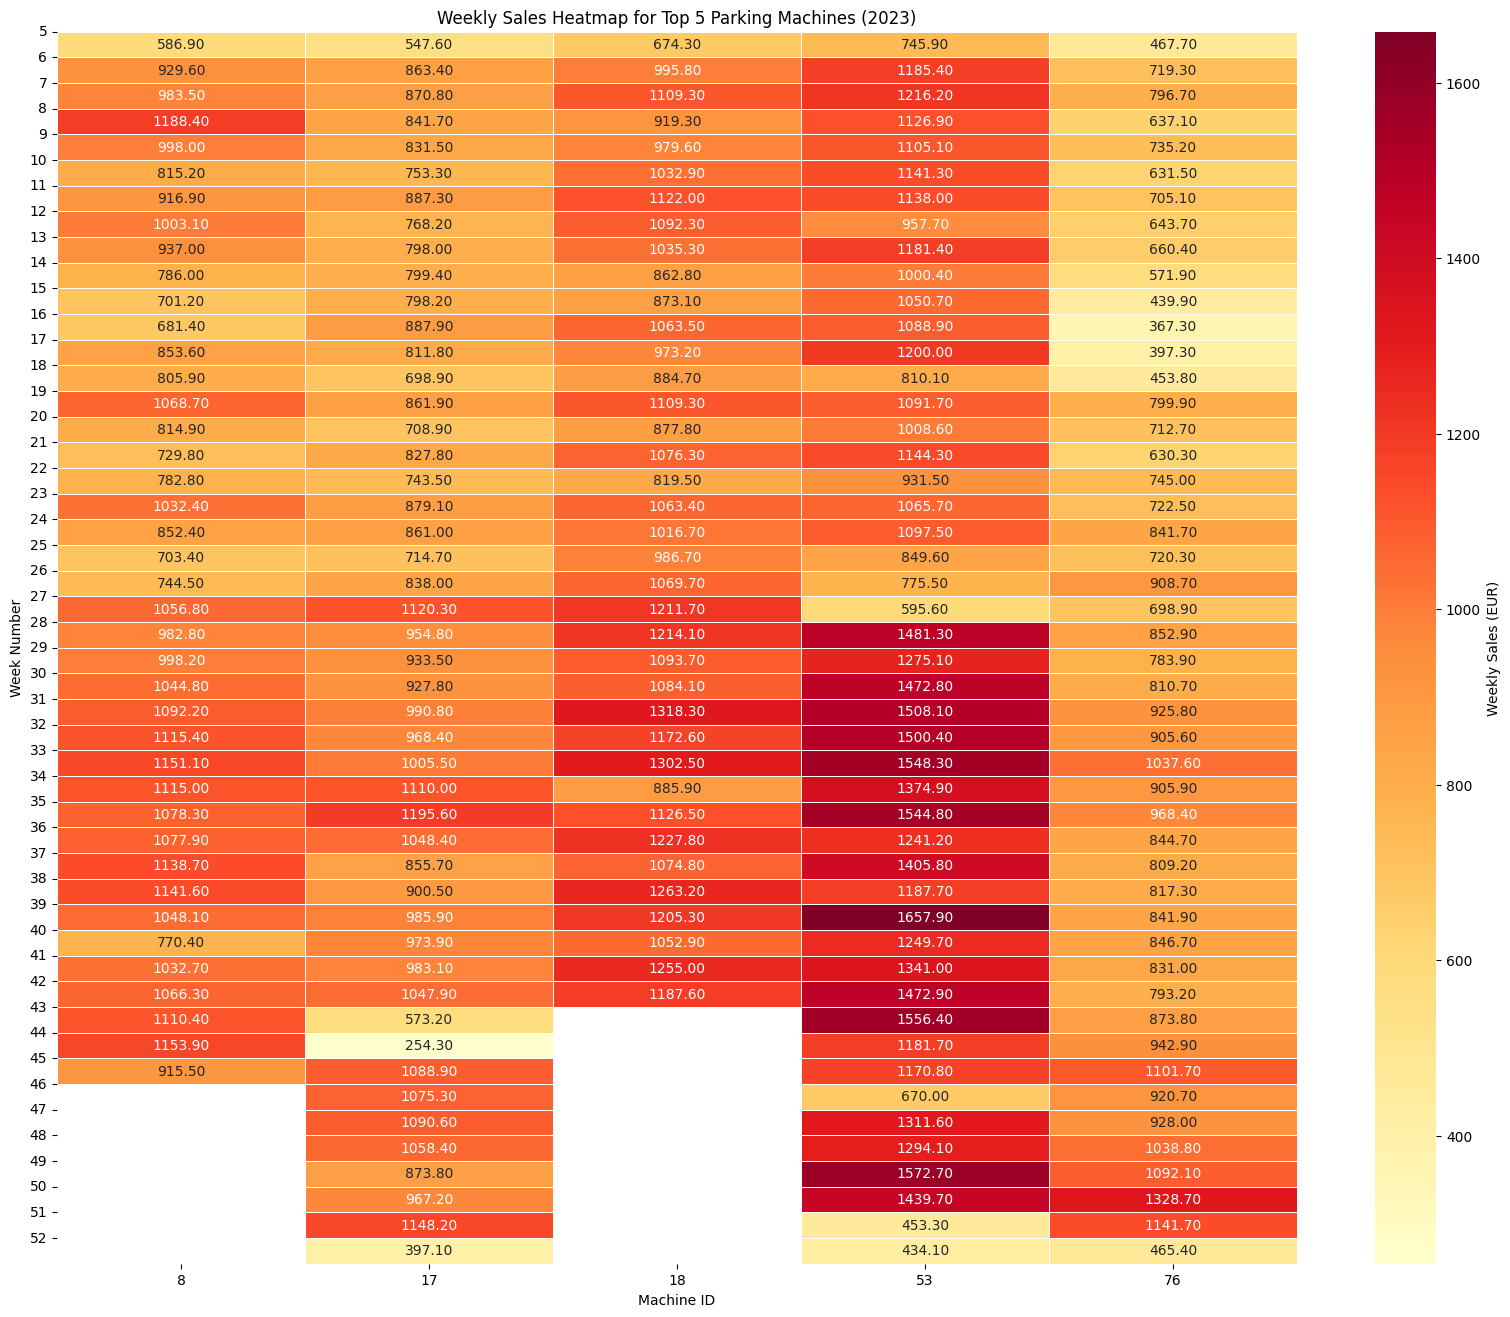

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

machine_sales = sales_df[sales_df["category"] == "machine"]
top_5_by_sales = (
    machine_sales.groupby("machine_ID")["fee"].sum().nlargest(5, "first")
)

weekly_sales = machine_sales[machine_sales["machine_ID"].isin(top_5_by_sales.index)]
weekly_sales = (
    weekly_sales.groupby([pd.Grouper(freq="W"), "machine_ID"])["fee"]
    .sum()
    .reset_index()
)

# We pivot the data to make it easier to plot
pivot_data = weekly_sales.pivot(index="time", columns="machine_ID", values="fee")

pivot_data["week_number"] = pivot_data.index.isocalendar().week

plt.figure(figsize=(20, 16))

ax = sns.heatmap(
    pivot_data.iloc[:, :-1],
    cmap="YlOrRd",
    cbar_kws={"label": "Weekly Sales (EUR)"},
    annot=True,
    fmt=".2f",
    linewidths=0.5,
)

plt.xticks(rotation=0)

# Set y-axis ticks to show every week number
ax.set_yticks(range(len(pivot_data)))
ax.set_yticklabels(pivot_data["week_number"], rotation=0)

plt.title("Weekly Sales Heatmap for Top 5 Parking Machines (2023)")
plt.xlabel("Machine ID")
plt.ylabel("Week Number")
#plt.savefig("out/top_5_machines_heatmap.png", dpi=300)
plt.show()

#### 2.1.2 (5 points)
The location of the machines might also have an influence on the turnover. 

Familiarize yourself with the function `plot_map` from the library `dsplotter`. Use the function to plot the yearly turnover for each location. Make the color **and** the radius of the location marker dependent on the yearly turnover. Can you see any relationship between the machines with a high yearly turnover? 

In [7]:
from dsplotter import plot_map

yearly_sales_by_machine: pd.DataFrame = (
    sales_df[sales_df["category"] == "machine"]
    .groupby("machine_ID")[["fee", "latitude_machine", "longitude_machine"]]
    .agg(
        {
            "fee": "sum",
            "latitude_machine": "first",
            "longitude_machine": "first",
        }
    )
).reset_index()  # reset_index() ensures that we get a DataFrame, which is only needed to silence the LSP (no functional difference)

yearly_sales_by_machine = yearly_sales_by_machine.rename(
    columns={
        "fee": "yearly_sales_eur",
        "latitude_machine": "latitude",
        "longitude_machine": "longitude",
    }
)

#yearly_sales_by_machine.info()

#print(yearly_sales_by_machine)

plot_map(
    yearly_sales_by_machine, "yearly_sales_eur", "yearly_sales_eur", radius_scale=10
)

# Observation regarding shared characteristics of machines with high sales volume:
# Lesser distance to city center -> higher sales volume
# Lesser distance to z-campus -> higher sales volume
# ...?

### Exercise 2.2 - Analysis of Machine and App Usage per Zone (27 points)
As part of the city's digitization initiative, the Parkster app was introduced a few years ago as an alternative to parking machines. 
So far we have focused only on the parking machines and therefore discarded a bulk of ticket sales.
The city would like to carry out an initial visual analysis of the acceptance of the app in the individual parkzones in 2023 and analysis the total parking turnover. 

*Note that we can only analyse the total parking ticket sales by summarizing all parking machines per parkzone.*

#### 2.2.1 (6 points)
Do users prefer the app or the machine usage? 

Use an appropriate plot to show the average machine or app usage rate per **parkzone** for the whole year of 2023. What do you observe?

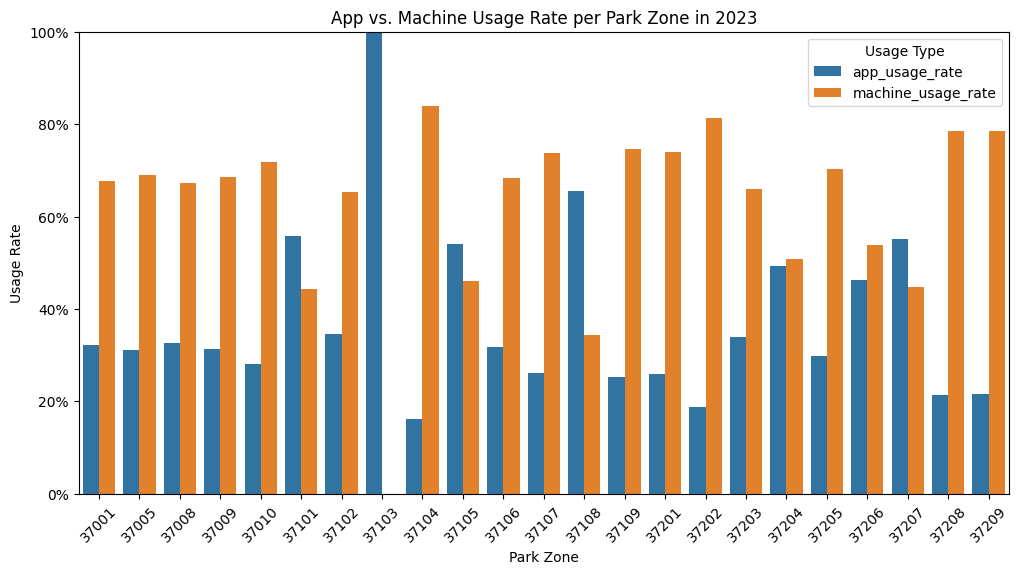

In [8]:
import matplotlib.ticker as mticker

zone_agg = sales_df.groupby("zone").size().to_frame(name="total_transactions")

zone_agg["total_sales_volume"] = sales_df.groupby("zone")["fee"].sum()

transactions_by_category = sales_df.groupby(["zone", "category"]).size()

# Pivot the result to have `category` as columns
transactions_by_category = transactions_by_category.unstack(fill_value=0)

transactions_by_category = transactions_by_category.rename(
    columns={"app": "transactions_app", "machine": "transactions_machine"}
)

sales_volume_by_category = sales_df.groupby(["zone", "category"])["fee"].sum()

sales_volume_by_category = sales_volume_by_category.unstack(fill_value=0)
sales_volume_by_category = sales_volume_by_category.rename(
    columns={"app": "sales_volume_app", "machine": "sales_volume_machine"}
)

df221 = zone_agg.join(transactions_by_category).join(sales_volume_by_category)

df221 = df221.reset_index()

df221["app_usage_rate"] = df221["transactions_app"] / df221["total_transactions"]
df221["machine_usage_rate"] = (
    df221["transactions_machine"] / df221["total_transactions"]
)

df_melted221 = df221.melt(
    id_vars=["zone"],
    value_vars=["app_usage_rate", "machine_usage_rate"],
    var_name="variable",
    value_name="value",
)

plt.figure(figsize=(12, 6))
sns.barplot(x="zone", y="value", hue="variable", data=df_melted221)

plt.xlabel("Park Zone")
plt.ylabel("Usage Rate")
plt.title("App vs. Machine Usage Rate per Park Zone in 2023")
plt.xticks(rotation=45)
plt.legend(title="Usage Type")

plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
plt.ylim(0.0, 1.0)

#plt.savefig("out/2.2.1.png")
plt.show()

### 2.2.1 - Interpretation
Overall, parkers prefer using machines to using the app. This is true for all but a few zones, notably `37103` which either doesn't have parking machines or is missing some data.

#### 2.2.2 (9 points)
How frequently are the individual parkzones used? 

Visualize the total number of parking tickets and the machine usage for each parkzone in 2023 in one plot. Use the a `log`-scale for the y-axis. What do you observe?

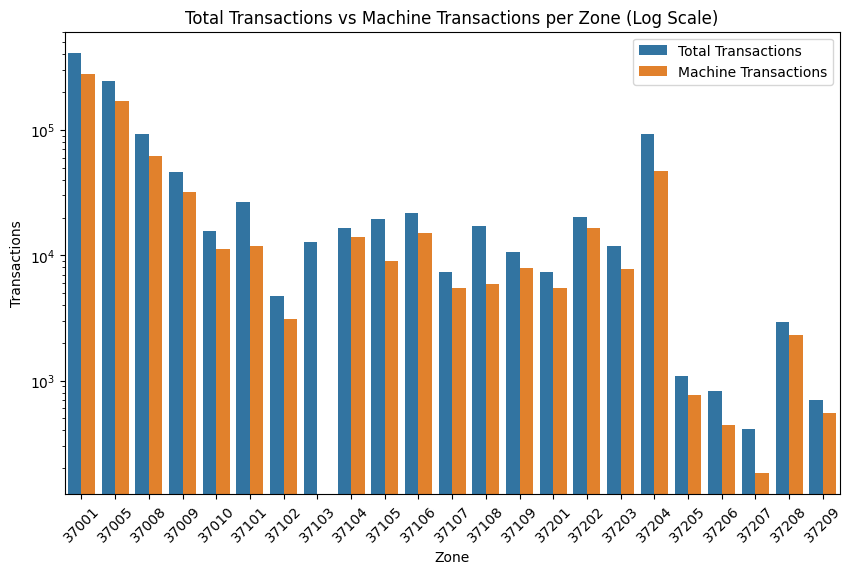

In [9]:
df_melted221 = df221.melt(
    id_vars=["zone"],
    value_vars=["total_transactions", "transactions_machine"],
    var_name="variable",
    value_name="value",
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="zone", y="value", hue="variable", data=df_melted221)
handles, labels = ax.get_legend_handles_labels()
custom_labels = ["Total Transactions", "Machine Transactions"]
ax.legend(handles, custom_labels)

plt.yscale("log")

plt.title("Total Transactions vs Machine Transactions per Zone (Log Scale)")
plt.xlabel("Zone")
plt.ylabel("Transactions")

plt.xticks(rotation=45)

# plt.savefig("out/2.2.2.png")
plt.show()

##### 2.2.2 - Obersvation
We observe that the vast majority of transactions where made using parking machines in most zones, with the notable exception of zone 37103, where no machine transactions are recorded in our data.

#### 2.2.3 (7 points)
The previous plot gives us an idea about the total number of *users* per parkzone. This number is likely highly correlated with the number of parking lots per zone. If we want to compare different parkzones with regard to their parking tickets sold, we should normalize them by the number of parking lots available. This way we can find out which zones are used most frequently. Because we don't have the number of parking lots available for each zone, we can only use the number of parking machines as a rough approximation for their sizes. 

Use the information from the `psa_latlong.csv` and reproduce the previous plot using the number of parking tickets normalized by the number of machines for each zone. Use the a `log`-scale for the y-axis.
Which parkzone is the busiest one?

The busiest parkzone is: 37204


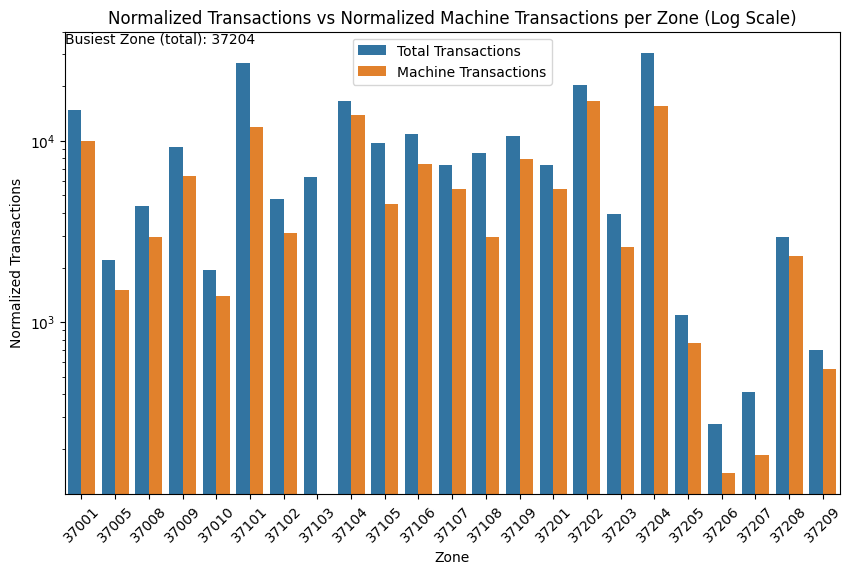

In [10]:
machines_per_zone = (
    psa_latlong_df.groupby("zone").size().to_frame(name="machines_per_zone")
)

df223 = df221.merge(machines_per_zone, on="zone")
# df221.info()
# print(df221.head(5))

df223["normalized_transactions"] = (
    df223["total_transactions"] / df223["machines_per_zone"]
)
df223["normalized_machine_transactions"] = (
    df223["transactions_machine"] / df223["machines_per_zone"]
)

busiest_zone = df223.loc[df223["normalized_transactions"].idxmax(), "zone"]
print(f"The busiest parkzone is: {busiest_zone}")

# Melt the dataframe to have `normalized_transactions` and `normalized_machine_transactions` in one column
df_melted223 = df223.melt(
    id_vars=["zone"],
    value_vars=["normalized_transactions", "normalized_machine_transactions"],
    var_name="variable",
    value_name="value",
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="zone", y="value", hue="variable", data=df_melted223)
handles, labels = ax.get_legend_handles_labels()
custom_labels = ["Total Transactions", "Machine Transactions"]
ax.legend(handles, custom_labels)

plt.yscale("log")
plt.title(
    "Normalized Transactions vs Normalized Machine Transactions per Zone (Log Scale)"
)
plt.xlabel("Zone")
plt.ylabel("Normalized Transactions")
plt.xticks(rotation=45)

plt.text(
    0.0,
    1.0,
    f"Busiest Zone (total): {busiest_zone}",
    transform=plt.gca().transAxes,
    ha="left",
    va="top",
)

# plt.savefig("out/2.2.3.png")
plt.show()

#### 2.2.4 (5 points)
So far we haven't used the geographical information of the parkzones. 

Use the `plot_map`-function to plot the location (center) of all parkzones, their average tickets sold per machine and the rate of machine users. Color the location by the rate of machine users and set the radius using the tickets sold per machine. What do you observe?

In [11]:
parkzones_latlong = pd.read_pickle("pickles/parkzones_latlong")
parkzones_latlong.info()
df224 = df221.merge(parkzones_latlong, on="zone")
plot_map(df224, "machine_usage_rate", "transactions_machine", radius_scale=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   23 non-null     float64
 1   longitude  23 non-null     float64
 2   zone       23 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 684.0 bytes


##### 2.2.4 Obersvations
- In most zones, machine usage is greater than app usage
- Zones inside of-and-surrounding the city center and Südstadt area have high numbers of total transactions

___
## Exercise 3: Statistics (18 points)


#### Exercise 3.1 - t-Test (13 points)
In addition to our visual analysis, we now also want to carry out a statistical study of machine vs. app usage.

To do this, determine the daily rate of machine use per parkzone. Carry out a t-test **for each parkzone**, which statistically tests whether parkers prefer to use the app in the respective zone. Write down the corresponding pair of hypotheses, carry out the test and interpret your test results. Use a significance level of 0.05 for your test decision. Which fundamental assumption of the statistical test could be violated?

### 3.1 - Approach

To statistically test whether parkers prefer to use the app or the machine in each parkzone, we will conduct a one-sample t-test for each zone. 

* **$H_0$**: The population mean rate of machine use in a given zone is less than or equal to 0.5 (indicating no preference for the machine or a preference for the app).

* **$H_A$**: The population mean rate of machine use in a given zone is greater than 0.5 (indicating a preference for the machine).

We will use a significance level of 0.05 for our test decisions. If the p-value is less than 0.05, we will reject the null hypothesis and conclude that there is evidence of a preference for the machine in that zone. Otherwise, we will fail to reject the null hypothesis, indicating no significant evidence of a preference for the machine.

We acknowledge that the assumption of normality for the t-test might be violated, as the daily rate of machine use might not be normally distributed. If this is the case, the results of the t-test should be interpreted with caution, especially for zones with smaller sample sizes.


In [12]:
from scipy import stats

# 1. Determine daily rate of machine use per parkzone
daily_sales_parkzone = sales_df.groupby([pd.Grouper(freq="D"), "zone"])
daily_sales_parkzone_app = sales_df[sales_df["category"] == "app"].groupby(
    [pd.Grouper(freq="D"), "zone"]
)
daily_sales_parkzone_machine = sales_df[sales_df["category"] == "machine"].groupby(
    [pd.Grouper(freq="D"), "zone"]
)
sales_counts = daily_sales_parkzone["fee"].count().to_frame(name="sales_total")

# sales_counts["sales_app"] = daily_sales_parkzone_app["fee"].count()
sales_counts["sales_machine"] = daily_sales_parkzone_machine["fee"].count()
sales_counts = sales_counts.astype(
    {"sales_total": "int64", "sales_machine": "Int64"}
)

sales_counts["rate_machine"] = (
    sales_counts["sales_machine"] / sales_counts["sales_total"]
)
sales_counts["rate_machine"] = sales_counts["rate_machine"].fillna(0.0)

average_machine_usage_per_zone = sales_counts.groupby(["zone"])[
    "rate_machine"
].mean()

for zone, rate_machine in average_machine_usage_per_zone.items():
    rate_app = 1 - rate_machine

    zone_data = sales_counts.xs(zone, level="zone")

    sample_size = zone_data.shape[0]

    print(f"sample size: {sample_size}")

    # statistic, p_value_normality = stats.shapiro(zone_data["rate_machine"])
    # print(f"Zone {zone}: Shapiro-Wilk Test p-value = {p_value_normality:.4f}")
    # print(f"Zone {zone}: Shapiro-Wilk Test statistic = {statistic:.4f}")


    t_statistic, p_value = stats.ttest_1samp(
        zone_data["rate_machine"], 0.5, alternative="greater"
    )

    if p_value < 0.05:
        print(
            f"Zone {zone}: Reject H0. Parkers prefer to use the machine. (p-value = {p_value:.4f})"
        )
    else:
        print(
            f"Zone {zone}: Fail to reject H0. No evidence of preference for the machine. (p-value = {p_value:.4f})"
        )

sample size: 335
Zone 37001: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 335
Zone 37005: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 332
Zone 37008: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 323
Zone 37009: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 327
Zone 37010: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 325
Zone 37101: Fail to reject H0. No evidence of preference for the machine. (p-value = 1.0000)
sample size: 308
Zone 37102: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 316
Zone 37103: Fail to reject H0. No evidence of preference for the machine. (p-value = 1.0000)
sample size: 308
Zone 37104: Reject H0. Parkers prefer to use the machine. (p-value = 0.0000)
sample size: 328
Zone 37105: Fail to reject H0. No evidence of preference for the machine. (p-value = 1.0000)
sample size:

### 3.1 - Interpretation
The results of the t-tests indicate that in the majority of parkzones, there is a statistically significant preference for using the machine over the app for payment.

#### Exercise 3.2 - Statistical Reasoning (5 points)
Assume that for zone `37106` the rate of app users (and thus the rate of machine users) is `0.5`. 
The city sends you the data for 2024. 

How many days can you expect the app usage rate to be significantly greater than the machine usage rate at a significance level of 5%? Explain why that is the case. Assume that the behavior of the users has not changed compared to 2023.

We'll use the mean machine use rate for zone `37106` to estimate the standard deviation of the machine use rate. We'll then use this standard deviation to calculate how many days we can expect the app usage rate to be significantly greater than the machine usage rate.

Since we're assuming the rate of app users and machine users is 0.5, the expected value (mean) of the machine use rate is also 0.5. We'll use a one-sample t-test to test if the sample mean is significantly different from the expected value.

We know from the previous results that the t-statistic for zone `37106` is `0.7413`. We also know that the p-value for this zone is `0.0000`, which means we rejected the null hypothesis that the mean machine use rate is less than or equal to 0.5. This implies that the t-statistic is positive.

We'll use the following formula to calculate the standard deviation:

$t = (x̄ - μ) / (s / \sqrt{n})$

where:

* t is the t-statistic
* x̄ is the sample mean
* μ is the population mean (expected value)
* s is the sample standard deviation
* n is the sample size

We'll rearrange to solve for `s`:

$s = (x̄ - μ) / (t / \sqrt{n})$

We'll then use this standard deviation to calculate the critical value for a one-sample t-test at a 5% significance level. We'll use this critical value to calculate how many days we can expect the app usage rate to be significantly greater than the machine usage rate.

We'll calculate the standard deviation and the critical value:

In [13]:
from scipy.stats import t
sample_mean = 0.7413
population_mean = 0.5
t_statistic = 0.7413
sample_size = 307

standard_deviation = (sample_mean - population_mean) / (t_statistic / (sample_size ** 0.5))

critical_value = t.ppf(0.95, sample_size - 1)

print(f"Standard Deviation: {standard_deviation:.4f}")
print(f"Critical Value: {critical_value:.4f}")

Standard Deviation: 5.7034
Critical Value: 1.6498


We have Now we'll calculate the critical machine use rate, which is the machine use rate below which we can reject the null hypothesis that the mean machine use rate is greater than or equal to 0.5 (or in other words, the app usage rate is significantly greater than the machine usage rate).

We'll use the following formula to calculate the critical machine use rate:

$\text{critical_machine_use_rate} = \text{population_mean} - (\text{critical_value} * (\text{standard_deviation} / \sqrt{n}))$

where:

* c=population_mean is 0.5
* critical_value is 1.6491
* standard_deviation is 6.2188
* n is 307

Finally, we'll calculate how many days we can expect the machine use rate to be below this critical machine use rate. We'll assume the machine use rate follows a normal distribution with the mean and standard deviation we calculated earlier. We'll use the cumulative distribution function (CDF) of the normal distribution to calculate this.


In [14]:
from scipy.stats import norm

critical_machine_use_rate = population_mean - (critical_value * (standard_deviation / (sample_size ** 0.5)))

probability = norm.cdf(critical_machine_use_rate, population_mean, standard_deviation)

expected_days = round(probability * 365)

print(f"Expected number of days with app usage significantly greater than machine usage: {expected_days}")

Expected number of days with app usage significantly greater than machine usage: 169


We can expect the app usage rate to be significantly greater than the machine usage rate on approximately **169 days** in 2024 for zone 37106.

This is because we're assuming the underlying distribution of machine use rates hasn't changed from 2023. We used the 2023 data to estimate the standard deviation of this distribution. Then, we calculated the critical machine use rate, below which we can reject the null hypothesis that the mean machine use rate is greater than or equal to 0.5 (i.e., the app usage is significantly greater). Finally, we used the estimated distribution to calculate how many days we can expect the machine use rate to fall below this critical value. 

___
## Exercise 4: Machine Learning (20 points)

Use the k-Nearest Neighbors (k-NN) algorithm to build a machine learning model that predicts the parking method (app or machine) based on location and fee as input features. Use parking data between fee value 2 euros and 7 euros.

#### Excersice 4.1 - Model Building and Hyperparameter Search (10 points)
Preprocess the data appropriately, perform hyperparameter search with cross validation for the optimal k value, visualize your optimal choice of k and finally use your optimal k-value to build the model.

**Hint:** Use 30% of all the data to speed up hyperparameter search and use the whole dataset for model building

#### Exercise 4.2 - Visualizing Model Predictions (10 points)
Create a `100 x 100` grid of longitude/latitude values using the min and max values from your dataset and visualize the predictions of the k-NN model **for three different parking fees** - 3, 5, and 7 euros, using the `plot_map` function. Set the color of the markers on the map to your prediction. Point out at least 2 visual changes in the predicted pattern of parking method across the city for these three different fee values.